In [1]:
import pandas as pd
import numpy as np
import os
import json
import yaml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification

from src.preprocessing import clean_data, get_features, get_dataloader
from src.training import train_and_evaluate
from src.evaluation import plot_losses, plot_confusion_matrix

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
epochs = 5
batch_size = 32
model_name = 'bert-base-uncased'
lr = 2e-5

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
os.listdir("data")

['tokens.yml',
 'firstname_with_sex.csv',
 'entities.json',
 'transcriptions_with_sex.csv']

In [5]:
with open("data/tokens.yml") as f:
    raw_tokens = yaml.safe_load(f)

with open("data/entities.json") as f:
    raw_data = json.load(f)

In [6]:
tokens = {key: value['start'] for key, value in raw_tokens.items()}
tokens

{'age': 'Ⓐ',
 'birth_date': 'Ⓑ',
 'civil_status': 'Ⓒ',
 'education_level': 'Ⓓ',
 'employer': 'Ⓔ',
 'firstname': 'Ⓕ',
 'link': 'Ⓗ',
 'lob': 'Ⓘ',
 'maiden_name': 'Ⓙ',
 'nationality': 'Ⓚ',
 'observation': 'Ⓛ',
 'occupation': 'Ⓜ',
 'surname': 'Ⓞ',
 'surname_household': 'Ⓟ'}

In [7]:
data = clean_data(raw_data, tokens)

In [8]:
data

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household
0,25,NaN,Garçon,NaN,NaN,Cyrille,NaN,NaN,NaN,française,NaN,menuisier,Breton,NaN
1,30,NaN,Garçon,NaN,NaN,Auguste,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Ferazzi
2,24,NaN,Garçon,NaN,NaN,Pierre,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Machol
3,48,NaN,Homme,NaN,NaN,Alexandre,NaN,NaN,NaN,française,NaN,prop,NaN,Desbois
4,30,NaN,NaN,NaN,NaN,Zélie,sa,NaN,NaN,française,NaN,prop,Vignat,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25443,NaN,1887,NaN,NaN,NaN,Annunziata,épouse,idem,NaN,idem,NaN,NaN,Berni-Laureti,NaN
25444,NaN,1914,NaN,NaN,NaN,Primo,fils,idem,NaN,idem,NaN,NaN,Berni,NaN
25445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
X, y = get_features(data)
X, X.shape, y.shape

(array(['25 Garçon Cyrille française menuisier Breton',
        '30 Garçon Auguste Piémontaise vitrier',
        '24 Garçon Pierre Piémontaise vitrier', ..., '', '', ''],
       dtype='<U79'),
 (25448,),
 (25448,))

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, stratify=y, random_state=seed)

In [12]:
tokenizer = BertTokenizer.from_pretrained(model_name)

In [13]:
train_dataloader = get_dataloader(X_train, y_train, tokenizer, batch_size=batch_size)
val_dataloader = get_dataloader(X_val, y_val, tokenizer, batch_size=batch_size)

In [14]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(np.unique(y_train)))
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters to be learned: {n_params}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters to be learned: 109483778


In [15]:
train_losses, val_losses, val_accuracies = train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, device, epochs)

======== Epoch 1 / 5 ========


100%|██████████| 637/637 [01:53<00:00,  5.60it/s]


  Average training loss: 0.12
Validation Loss: 0.05
Validation Accuracy: 0.99
======== Epoch 2 / 5 ========


100%|██████████| 637/637 [01:52<00:00,  5.67it/s]


  Average training loss: 0.04
Validation Loss: 0.06
Validation Accuracy: 0.99
======== Epoch 3 / 5 ========


100%|██████████| 637/637 [01:49<00:00,  5.79it/s]


  Average training loss: 0.03
Validation Loss: 0.08
Validation Accuracy: 0.99
======== Epoch 4 / 5 ========


100%|██████████| 637/637 [01:49<00:00,  5.81it/s]


  Average training loss: 0.02
Validation Loss: 0.05
Validation Accuracy: 0.99
======== Epoch 5 / 5 ========


100%|██████████| 637/637 [01:49<00:00,  5.81it/s]


  Average training loss: 0.01
Validation Loss: 0.05
Validation Accuracy: 0.99
Training time (seconds): 593.21


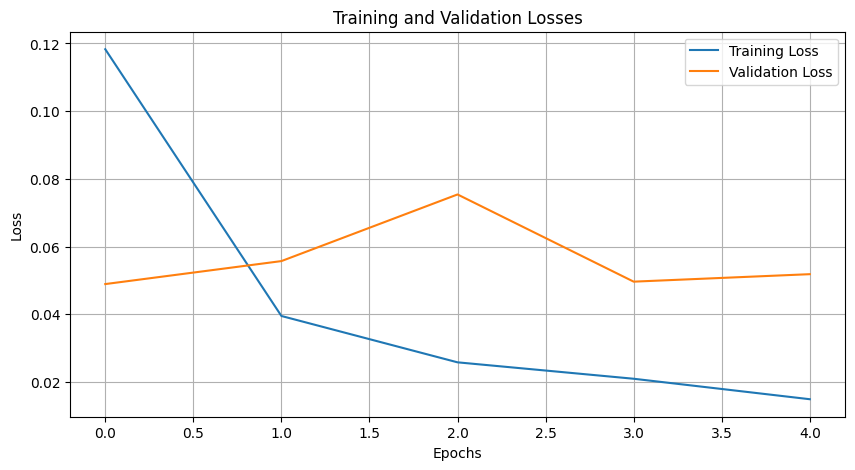

In [34]:
plot_losses(train_losses, val_losses)

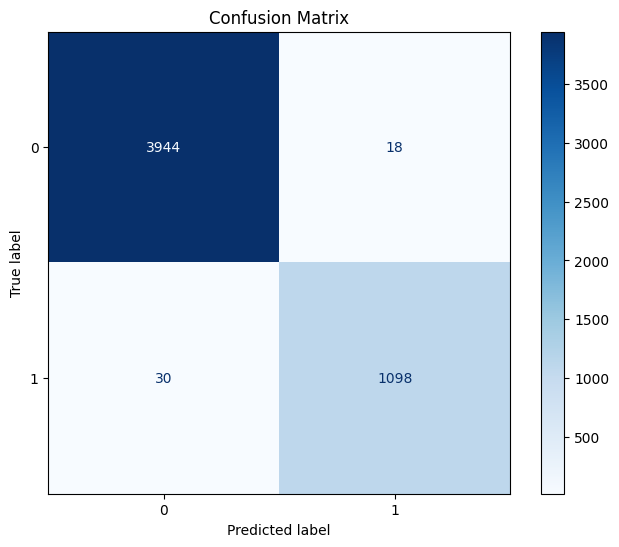

In [36]:
true_labels, predictions = predict(model, val_dataloader, device)
plot_confusion_matrix(true_labels, predictions)

In [30]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3962
           1       0.98      0.97      0.98      1128

    accuracy                           0.99      5090
   macro avg       0.99      0.98      0.99      5090
weighted avg       0.99      0.99      0.99      5090



In [31]:
# comparer egalement avec camembert et flaubert + benchmarker les temps d'inférence